     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 794.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.5 MB/s eta 0:00:00


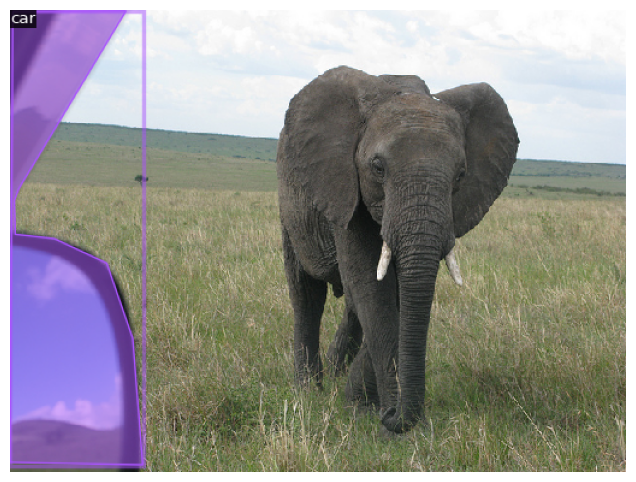

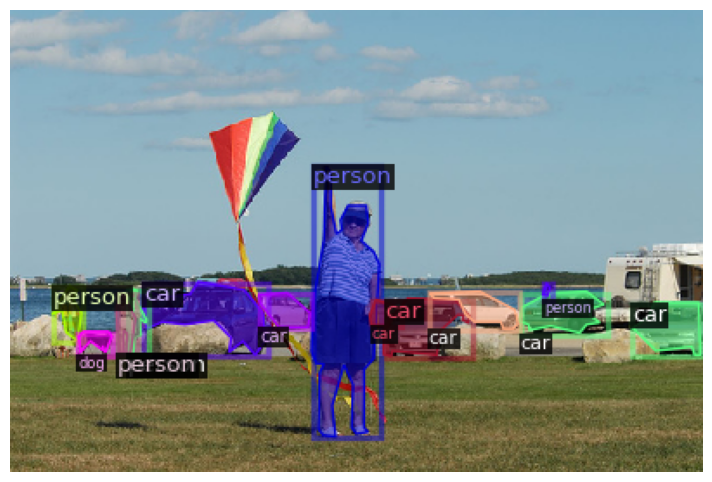

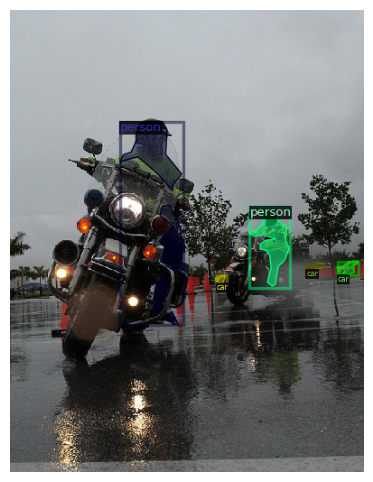

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [1]:
# Step 1: Environment Setup (run only once, then restart runtime)
!pip install -q cython==0.29.36 pyyaml==5.1
!pip install -q pycocotools==2.0.2 --force-reinstall
!pip install -q 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -q git+https://github.com/facebookresearch/detectron2.git

# Step 2: Drive Access
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Core Libraries
import os
import json
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Step 4: Dataset Path and Classes
project_root = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset'
categories_of_interest = {"person": 0, "dog": 1, "car": 2, "cake": 3}

# Step 5: Sanitize COCO Annotations (filter to selected classes only)
def sanitize_annotations(directory_name):
    ann_path = os.path.join(project_root, directory_name, 'labels.json')
    with open(ann_path, 'r') as f:
        coco_data = json.load(f)

    selected_anns = []
    valid_image_ids = set()
    valid_names = set(categories_of_interest.keys())

    for ann in coco_data['annotations']:
        for cat in coco_data['categories']:
            if ann['category_id'] == cat['id'] and cat['name'] in valid_names:
                if not ann.get("segmentation") or not ann.get("bbox"):
                    continue
                new_ann = ann.copy()
                new_ann['category_id'] = categories_of_interest[cat['name']]
                selected_anns.append(new_ann)
                valid_image_ids.add(ann['image_id'])
                break

    filtered_images = [img for img in coco_data['images'] if img['id'] in valid_image_ids]
    updated_categories = [{"id": v, "name": k} for k, v in categories_of_interest.items()]
    cleaned_coco = {
        "images": filtered_images,
        "annotations": selected_anns,
        "categories": updated_categories
    }

    out_json = os.path.join(project_root, directory_name, 'labels_filtered.json')
    with open(out_json, 'w') as f_out:
        json.dump(cleaned_coco, f_out)

    print(f"\nCategory counts in {directory_name}:")
    counts = Counter([a["category_id"] for a in selected_anns])
    for k, v in sorted(counts.items()):
        label = [name for name, idx in categories_of_interest.items() if idx == k][0]
        print(f"  {label}: {v} instances")

# Step 6: Prepare Train and Validation Sets
sanitize_annotations('train-300')
sanitize_annotations('validation-300')

# Unregister datasets if already registered (to avoid duplicate registration)
if "coco_train" in DatasetCatalog.list():
    DatasetCatalog.remove("coco_train")
    MetadataCatalog.remove("coco_train")

if "coco_val" in DatasetCatalog.list():
    DatasetCatalog.remove("coco_val")
    MetadataCatalog.remove("coco_val")

register_coco_instances("coco_train", {}, f"{project_root}/train-300/labels_filtered.json", f"{project_root}/train-300/data")
register_coco_instances("coco_val", {}, f"{project_root}/validation-300/labels_filtered.json", f"{project_root}/validation-300/data")

# Update Metadata for correct label display
MetadataCatalog.get("coco_train").thing_classes = list(categories_of_interest.keys())
MetadataCatalog.get("coco_val").thing_classes = list(categories_of_interest.keys())

# Step 7: Visualize Random Training Samples
def show_sample(dataset_name, number=3):
    metadata = MetadataCatalog.get(dataset_name)
    dataset = DatasetCatalog.get(dataset_name)
    for _ in range(number):
        sample = random.choice(dataset)
        img = cv2.imread(sample["file_name"])
        vis = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE)
        out = vis.draw_dataset_dict(sample)
        plt.figure(figsize=(10, 6))
        plt.imshow(out.get_image())
        plt.axis('off')
        plt.show()

show_sample("coco_train")

# Step 8: Configuration Setup
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coco_train",)
cfg.DATASETS.TEST = ("coco_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.BASE_LR = 1e-4
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 200
cfg.TEST.EVAL_PERIOD = 200
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.OUTPUT_DIR = "/content/instance_seg_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Step 9: Train the Model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 10: Inference on Test Images
predictor = DefaultPredictor(cfg)
test_img_dir = os.path.join(project_root, 'test-30')
test_images = [f for f in os.listdir(test_img_dir) if f.endswith('.jpg') or f.endswith('.png')]

for fname in test_images[:3]:
    img_path = os.path.join(test_img_dir, fname)
    img = cv2.imread(img_path)
    outputs = predictor(img)
    vis = Visualizer(img[:, :, ::-1], MetadataCatalog.get("coco_train"), scale=1.0)
    out = vis.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image())
    plt.title(fname)
    plt.axis('off')
    plt.show()

# Step 11: Visualize Predictions on Validation Set
val_data = DatasetCatalog.get("coco_val")
for sample in random.sample(val_data, 3):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    vis = Visualizer(img[:, :, ::-1], MetadataCatalog.get("coco_val"), scale=1.0)
    out = vis.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image())
    plt.title("Validation Sample")
    plt.axis('off')
    plt.show()
